# Benchmark calculcations for January and June proposals

**A Note About Source Data**

We ran our original calculations using RMI's building data. The first set of models run in this notebook used the publicly available building data from 2019, with calculations to reproduce the new fields created in the RMI dataset. This gave us massively skewed results. We're not sure if this is because the datasets were really off from one another or there's a calculation error. This will need to be investigated.

At the bottom of the notebook are these same proposals remodelled with RMI's building data, which shows us results consistent with what we've seen in the past. 


**Assumptions**:

- Buildings will produce the max amount of emissions, **unless** their predicted emissions is lower than the target GHGI, in which case they will produce that amount.
- Predicted emissions are calculated based off of the emissions predictions found in [the emissions data input file](../data/input_data/energy_emissions.csv). 


For each building, in each year (2027-2050), we need to calculate (column references given refer to the 2027 calculations in [the original RMI spreadsheet](https://docs.google.com/spreadsheets/d/175uipAHHQHGelq7i1n9sKWQXNQi-B1IJiF6-XQRVnE8/edit#gid=1811888818):

- `city_ghgi_target`: The GHGI target, as calculated by the sum of: use type * city's target GHGI for that use type * percent of GFA for that use type, for each of the three given use types (col A). If there is no target for any of the use types, this is NaN. If a building is multi-use, and some of the building's uses have a compliance threshold, but others don't, use the expected GHGI (greenhouse gas emissions intensity) if nothing is changed as the GHGI for the portion of the building that is not subject to BEPS yet.
    - Example: A building is 50% retail and 50% multifamily housing. The target for retail in 2033 is 1.03 and there is no target for multifamily housing. This building would have a GHGI of 4.0 in 2033 if no changes were made to it. We estimate the GHGHI target as `(0.5 * 1.03) + (0.5 * 4.0) = 2.515`. 
    - NB: These numbers will be different than the RMI calculations. The RMI model mistakenly used a GHGI of zero for parts of buildings that are not yet subject to BEPS. So in the example above, RMI's model would list the GHGI target as`0.5 * 1.03 + 0.5 * 0 = 0.515`, which leaves out half the building. Then the target GHGI would actually go **up** when the multifamily part of the building became subject to BEPS! This model corrects that error.
- `expected_baseline`: The expected emissions if nothing is changed about the building, as calculated by the sum of: `total use energy for type * energy emissions factor for energy type` for the three energy types (col C)
- `expected_baseline_ghgi`: The expected GHGI if nothing is changed about the building (col B), as calculated by the `expected emissions / total GFA`
- `compliant_ghgi`: The expected GHGI if the building is compliant with BEPS, as defined by (col H):
    - if the BEPS GHGI target is lower than the expected GHGI, use the BEPS GHGI target
    - if the expected GHGI is lower than the BEPS GHGI target, use the expected GHGI
- `compliant_emissions`: The expected emissions if the building is compliant with BEPS, as defined by the `compliant GHGI * total GFA` (col J)
- `compliance_status`: Whether or not the building is compliant (col K):
    - yes: the baseline GHGI is lower than the expected compliant GHGI for this year
    - no: the baseline GHGI is higher than the expected compliant GHGI for this year
    - no requirement yet: the building doesn't have a compliance requirement for this year
- `compliance_fees`: Noncompliance fees. For years where buildings will be taxed for being noncompliant, this is `$2.50 * total GFA`    

In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from baseline_model import BaselineBEPSModel

In [5]:
pd.options.mode.chained_assignment = None

In [6]:
JAN_TARGETS_PATH = '../data/input_data/jan_proposal_emissions_targets.csv'
JUNE_TARGETS_PATH = '../data/input_data/june_proposal_emissions_targets.csv'
EMISSIONS_PATH = '../data/input_data/energy_emissions.csv'
BUILDING_DATA_PATH = '../data/input_data/Reproducing RMI building data cleaning/cleaned_building_data_with_policy_gfa_9_11.csv'

JAN_FINE_YEARS = [2027, 2030, 2035, 2040, 2045, 2050]
JUNE_FINE_YEARS = [2030, 2035, 2040, 2045, 2050]
FINE_PER_SQ_FT = 2.5

## January Proposal

In [7]:
jan_model = BaselineBEPSModel(EMISSIONS_PATH, JAN_TARGETS_PATH, BUILDING_DATA_PATH, JAN_FINE_YEARS, FINE_PER_SQ_FT)

In [8]:
jan_model.calculate_baseline_model(2027,2050)

Model calculations complete. Access the model dataframe as model_name.scenario_results


In [9]:
jan_model.scenario_results.head()

,OSEBuildingID,BuildingName,Total GFA for Policy,sq_ft_classification,LargestPropertyUseType OSE,SecondLargestPropertyUseType OSE,ThirdLargestPropertyUseType OSE,year,expected_baseline,expected_baseline_ghgi,city_ghgi_target,compliant_ghgi,compliant_emissions,compliance_status,compliance_fees
0,1,MAYFLOWER PARK HOTEL,88434.0,C,Hotel,NaN,NaN,2027.0,2.705014e+05,3.058794,3.058794,3.058794,2.705014e+05,No,221085.0
1,2,PARAMOUNT HOTEL,88502.0,C,Hotel,NaN,Restaurant,2027.0,2.843616e+05,3.213052,3.213052,3.213052,2.843616e+05,No,221255.0
2,3,WESTIN HOTEL (Parent Building),756493.0,A,Hotel,NaN,Recreation,2027.0,2.193901e+06,2.900095,2.220000,2.220000,1.679414e+06,No,1891232.5
3,5,HOTEL MAX,61320.0,C,Hotel,NaN,NaN,2027.0,2.934861e+05,4.786141,4.786141,4.786141,2.934861e+05,No,153300.0
4,8,WARWICK SEATTLE HOTEL,123445.0,B,Hotel,NaN,Recreation,2027.0,5.827520e+05,4.720742,2.220000,2.220000,2.740479e+05,No,308612.5


## Summary stats for January Proposal

In [10]:
jan_model.get_total_emissions_by_year()

Emissions by year calculations complete. Access the annual emissions dataframe as model_name.emissions_by_year


In [11]:
jan_model.emissions_by_year

,compliant_emissions
year,
2027.0,3.367781e+08
2028.0,3.239650e+08
2029.0,3.072631e+08
2030.0,2.779739e+08
2031.0,2.457496e+08
2032.0,2.236317e+08
2033.0,2.132235e+08
2034.0,2.032228e+08
2035.0,1.899611e+08


In [12]:
# Calculate percent of CO2 reduction by 2040

jan_model.get_percent_emissions_reduction_by_given_year(2040)

0.868468817112779

In [13]:
jan_model.emissions_by_year.sum()

compliant_emissions    3.227114e+09
dtype: float64

## June proposal

In [14]:
june_model = BaselineBEPSModel(EMISSIONS_PATH, JUNE_TARGETS_PATH, BUILDING_DATA_PATH, JUNE_FINE_YEARS, FINE_PER_SQ_FT)

In [15]:
june_model.calculate_baseline_model(2027,2050)

Model calculations complete. Access the model dataframe as model_name.scenario_results


In [16]:
june_model.scenario_results.head()

,OSEBuildingID,BuildingName,Total GFA for Policy,sq_ft_classification,LargestPropertyUseType OSE,SecondLargestPropertyUseType OSE,ThirdLargestPropertyUseType OSE,year,expected_baseline,expected_baseline_ghgi,city_ghgi_target,compliant_ghgi,compliant_emissions,compliance_status,compliance_fees
0,1,MAYFLOWER PARK HOTEL,88434.0,C,Hotel,NaN,NaN,2027.0,2.705014e+05,3.058794,3.058794,3.058794,2.705014e+05,No,0.0
1,2,PARAMOUNT HOTEL,88502.0,C,Hotel,NaN,Restaurant,2027.0,2.843616e+05,3.213052,3.213052,3.213052,2.843616e+05,No,0.0
2,3,WESTIN HOTEL (Parent Building),756493.0,A,Hotel,NaN,Recreation,2027.0,2.193901e+06,2.900095,2.900095,2.900095,2.193901e+06,No,0.0
3,5,HOTEL MAX,61320.0,C,Hotel,NaN,NaN,2027.0,2.934861e+05,4.786141,4.786141,4.786141,2.934861e+05,No,0.0
4,8,WARWICK SEATTLE HOTEL,123445.0,B,Hotel,NaN,Recreation,2027.0,5.827520e+05,4.720742,4.720742,4.720742,5.827520e+05,No,0.0


## Summary stats for June

In [17]:
june_model.get_total_emissions_by_year()

Emissions by year calculations complete. Access the annual emissions dataframe as model_name.emissions_by_year


In [18]:
june_model.emissions_by_year

,compliant_emissions
year,
2027.0,9.310595e+08
2028.0,9.310595e+08
2029.0,9.310595e+08
2030.0,8.970770e+08
2031.0,3.434390e+08
2032.0,3.103698e+08
2033.0,2.991555e+08
2034.0,2.839025e+08
2035.0,2.588789e+08


In [19]:
june_model.get_percent_emissions_reduction_by_given_year(2040)

0.8208085863032639

In [20]:
june_model.scenario_results.to_csv('../data/output_data/cleaned_public_data_june_scenario.csv')
june_model.emissions_by_year.to_csv('../data/output_data/cleaned_public_data_june_scenario_by_year.csv')

jan_model.scenario_results.to_csv('../data/output_data/cleaned_public_data_jan_scenario.csv')
jan_model.emissions_by_year.to_csv('../data/output_data/cleaned_public_data_jan_scenario_by_year.csv')

## Comparing January and June

In [21]:
june_model.emissions_by_year.sum()

compliant_emissions    6.613525e+09
dtype: float64

In [22]:
jan_model.emissions_by_year.sum()

compliant_emissions    3.227114e+09
dtype: float64

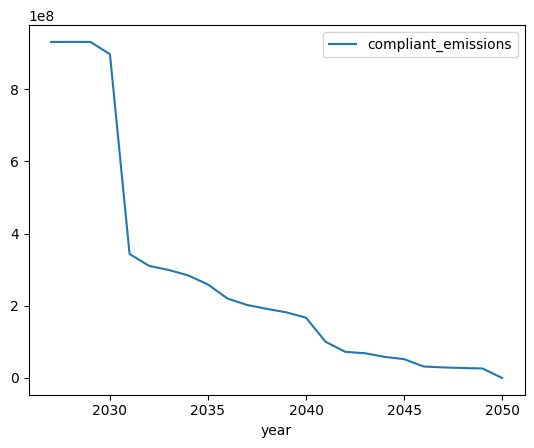

In [23]:
sns.lineplot(data=june_model.emissions_by_year)
plt.show()

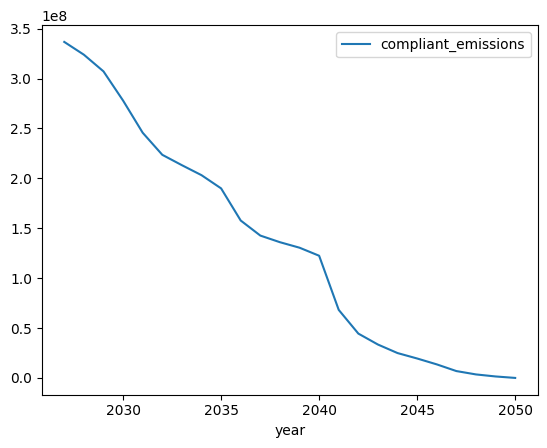

In [24]:
sns.lineplot(data=jan_model.emissions_by_year)
plt.show()

That's twice as much emissions in June vs January. Something is wrong. 

However, the steep drop in the June proposal isn't completely out of whack. What's going on is that the electricity emissions factor drops by 50% in 2030. So that's a huge reduction. Then the first targets go into effect in 2031. Between those two things, 

Let's look at the original RMI building spreadsheet.

## Proposals with Original RMI Spreadsheet

Something is wrong with the numbers we see above. Let's run the numbers again with the original RMI spreadsheet to verify that our model works correctly. If so, we can dig into what is wrong with the numbers we calculated for the public city data.

We'll rerun the numbers with the original RMI spreadsheet. Two things are added to this spreadsheet:

- building classification (A, B, C, etc. based on GFA that is subject to the policy)
- updated column names to match the model: 'Total_GFA' -> 'Total GFA for Policy', 'Steam(kBtu)' -> 'SteamUse(kBtu)', and 'percent_sqft_1st' -> 'LargestPropertyUseType Percent GFA', etc.

### January model

In [5]:
ORIG_BUILDING_DATA_PATH = '../data/input_data/rmi_building_analysis_with_new_col_names.csv'

In [6]:
orig_jan_model = BaselineBEPSModel(EMISSIONS_PATH, JAN_TARGETS_PATH, ORIG_BUILDING_DATA_PATH, JAN_FINE_YEARS, FINE_PER_SQ_FT)

In [7]:
orig_jan_model.calculate_baseline_model(2027, 2050)

Model calculations complete. Access the model dataframe as model_name.scenario_results


In [8]:
# Total emissions (kg) for Jan

orig_jan_model.scenario_results['compliant_emissions'].sum()

3430889229.1106

In [9]:
# Percent reduction by 2040

orig_jan_model.get_percent_emissions_reduction_by_given_year(2040)

0.7457294950189703

In [10]:
orig_jan_model.get_total_emissions_by_year()

Emissions by year calculations complete. Access the annual emissions dataframe as model_name.emissions_by_year


In [11]:
orig_jan_model.emissions_by_year

,compliant_emissions
year,
2027.0,3.406050e+08
2028.0,3.164388e+08
2029.0,2.984933e+08
2030.0,2.653944e+08
2031.0,2.405039e+08
2032.0,2.194513e+08
2033.0,2.009708e+08
2034.0,1.851488e+08
2035.0,1.702612e+08


In [13]:
orig_jan_model.scenario_results[orig_jan_model.scenario_results['LargestPropertyUseType OSE'] == np.nan ]

,OSEBuildingID,BuildingName,Total GFA for Policy,sq_ft_classification,LargestPropertyUseType OSE,SecondLargestPropertyUseType OSE,ThirdLargestPropertyUseType OSE,year,expected_baseline,expected_baseline_ghgi,city_ghgi_target,compliant_ghgi,compliant_emissions,compliance_status,compliance_fees


In [56]:
orig_jan_model.scenario_results.to_csv('../data/output_data/orig_rmi_data_jan_scenario.csv')
orig_jan_model.emissions_by_year.to_csv('../data/output_data/orig_rmi_data_jan_scenario_by_year.csv')

### June proposal

In [14]:
orig_june_model = BaselineBEPSModel(EMISSIONS_PATH, JUNE_TARGETS_PATH, ORIG_BUILDING_DATA_PATH, JUNE_FINE_YEARS, FINE_PER_SQ_FT)

In [15]:
orig_june_model.calculate_baseline_model(2027, 2050)

Model calculations complete. Access the model dataframe as model_name.scenario_results


In [16]:
orig_june_model.scenario_results['compliant_emissions'].sum()

4896559099.697521

In [17]:
orig_june_model.get_percent_emissions_reduction_by_given_year(2040)

0.65034777451687

In [18]:
orig_june_model.get_total_emissions_by_year()

Emissions by year calculations complete. Access the annual emissions dataframe as model_name.emissions_by_year


In [19]:
orig_june_model.emissions_by_year

,compliant_emissions
year,
2027.0,4.387396e+08
2028.0,4.387396e+08
2029.0,4.387396e+08
2030.0,4.051007e+08
2031.0,3.478464e+08
2032.0,3.148110e+08
2033.0,2.923256e+08
2034.0,2.757478e+08
2035.0,2.465763e+08


In [57]:
orig_june_model.scenario_results.to_csv('../data/output_data/orig_rmi_data_june_scenario.csv')
orig_june_model.emissions_by_year.to_csv('../data/output_data/orig_rmi_data_june_scenario_by_year.csv')

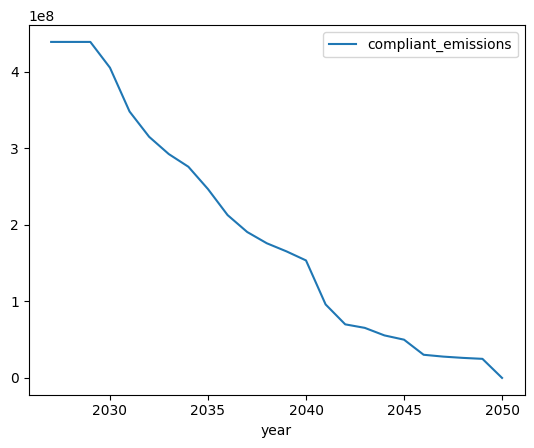

In [54]:
sns.lineplot(data=orig_june_model.emissions_by_year)
plt.show()

### Difference between January and June

How much less CO2 (in kgs) will be released with the original January plan vs. the original June plan?

In [20]:
1 - (orig_jan_model.scenario_results['compliant_emissions'].sum() / orig_june_model.scenario_results['compliant_emissions'].sum())

0.2993264945331633